# Library

In [ ]:
import numpy as np
import pandas as pd
import csv
from math import sqrt, pow
from time import time

from sentence_transformers import SentenceTransformer
from scipy import spatial
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, stem_text
from gensim.utils import simple_preprocess, tokenize
from gensim.models import Word2Vec, FastText, KeyedVectors

import tensorflow as tf
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate, Lambda, Flatten, Bidirectional
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import pickle

# Public Code

In [ ]:
test_data_AD = './Data/test_data.csv'
train_data_AD = './Data/train_data.csv'
valid_data_AD = './Data/valid_data.csv'

In [ ]:
#Test Data

file = open(test_data_AD)

csvreader = csv.reader(file)

header = []
header = next(csvreader)
header

test_data = []
for row in csvreader:
        test_data.append(row)
test_data

file.close()

In [ ]:
#Train Data

file = open(train_data_AD)

csvreader = csv.reader(file)

header = []
header = next(csvreader)
header

train_data = []
for row in csvreader:
        train_data.append(row)
train_data

file.close()

In [ ]:
#Validation Data

file = open(valid_data_AD)

csvreader = csv.reader(file)

header = []
header = next(csvreader)
header

valid_data = []
for row in csvreader:
        valid_data.append(row)
valid_data

file.close()

## Unique Train data

In [ ]:
qid2 = []
for i in range(len(train_data)) :
    qid2.append(train_data[i][2])

unique_res = list(np.unique(qid2))

train_sentence = []
for id in unique_res :
    index = qid2.index(id)
    train_sentence.append(train_data[index][4].lower())

print(len(qid2))
print(len(train_sentence))

37250
16663


In [ ]:
indexes = [train_sentence.index(x) for x in set(train_sentence)]
train_sentence = list(set(train_sentence))

print(len(indexes))
print(len(train_sentence))

16641
16641


In [ ]:
unique_qid2 = []
for i in indexes :
    unique_qid2.append(unique_res[i])

len(unique_qid2)

16641

## Unique Test questions

In [ ]:
qid1 = []
for i in range(len(test_data)) :
    qid1.append(test_data[i][1])

unique_qid1 = list(np.unique(qid1))

test_sentence = []
for id in unique_qid1 :
    index = qid1.index(id)
    test_sentence.append(test_data[index][3].lower())

print(len(qid1))
print(len(test_sentence))

980
146


## Unique Valid questions

In [ ]:
qid3 = []
for i in range(len(valid_data)) :
    qid3.append(valid_data[i][1])

qid3 = list(np.unique(qid3))

print(len(qid3))

173


## Assessment

#### MAP

In [ ]:
def MAP(precision) :
    if len(precision) == 0 :
        return 0
    
    s = 0
    for pre in precision :
        if len(pre) > 0 :
            x = 0
            for i in pre :
                x += i
            s += ( x / len(pre) )
        
    return s / len(precision)

#### P@k

In [ ]:
def Precision5(precision) :
    if len(precision) < 5 :
        return 0
    return precision[4]

In [ ]:
def Precision10(precision) :
    if len(precision) < 10 :
        return 0
    return precision[9]

#### MRR

In [ ]:
def MRR(reciprocal_rank, size) :
    if len(reciprocal_rank) == 0 :
        return 0
    
    s = 0
    for rr in reciprocal_rank :
        s += rr

    return s / size

#### Calculate

In [ ]:
def assessment(vector) :
    precision = []
    reciprocal_rank = []
    for i in range(len(vector)) :
        sort_index = np.argsort(vector[i])[::-1]
        sort_index = sort_index[0:10]

        index_pos_list = [ j for j in range(len(qid1)) if qid1[j] == unique_qid1[i] ]
        test_s = [test_data[j][-2].lower() for j in index_pos_list]
    
        pr = []
        sum = 0
        h = 0
        flag = True
        for index in sort_index :
            for z in range(len(train_data)) :
              if qid2[z] == unique_qid2[index] :
                train_s = train_data[z][-2].lower()
                if train_s in test_s :
                    sum += 1
                    pr.append(sum/(h + 1))
                    if flag :
                        flag = False
                        reciprocal_rank.append(1/(h + 1))
                h += 1
        precision.append(pr)
    
    
    precision5 = []
    precision10 = []
    mAP = []
    mRR = []
    for i in range(len(precision)) :
        precision5.append(Precision5(precision[i]))
        precision10.append(Precision10(precision[i]))
    
    mAP.append(MAP(precision))
    mRR.append(MRR(reciprocal_rank, len(precision)))

    return precision5, precision10, mAP, mRR

## Preprocess

In [ ]:
def remove_stop_words(sentences) :
    for i in range(len(sentences)) :
        sentences[i] = remove_stopwords(sentences[i].lower())
    
    return sentences

## Method

In [ ]:
filePath = './result/'

def save_list(myList, name) :
  open_file = open(filePath + name, "wb")
  pickle.dump(myList, open_file)
  open_file.close()

def load_list(name) :
  open_file = open(filePath + name, "rb")
  loaded_list = pickle.load(open_file)
  open_file.close()
  return loaded_list

# Bert

### Methods

In [ ]:
def squared_sum(x):
  """ return 3 rounded square rooted value """
 
  return round(sqrt(sum([a*a for a in x])),3)
 
def euclidean_distance(x,y):
  """ return euclidean distance between two lists """
 
  return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

In [ ]:
def cosine_similarity(x,y):
  """ return cosine similarity between two lists """
 
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

In [ ]:
def bert(sentences) :
  model = SentenceTransformer('bert-base-nli-mean-tokens')

  sentence_embeddings = model.encode(sentences)

  return sentence_embeddings

### Calculate

In [ ]:
train_sentences = remove_stop_words(train_sentence)

#se : sentence_embeddings
train_se = bert(train_sentences)

In [ ]:
test_sentences = remove_stop_words(test_sentence)

#se : sentence_embeddings
test_se = bert(test_sentences)

In [ ]:
cos = []
for test in test_se :
  c = []
  for train in train_se :
    c.append(cosine_similarity(test, train))
  
  cos.append(c)

In [ ]:
save_list(cos, "_cos")

In [ ]:
precision5, precision10, mAP, mRR = assessment(cos)

In [ ]:
save_list(precision5, "_p05")
save_list(precision10, "_p10")
save_list(mAP, "_MAP")
save_list(mRR, "_MRR")

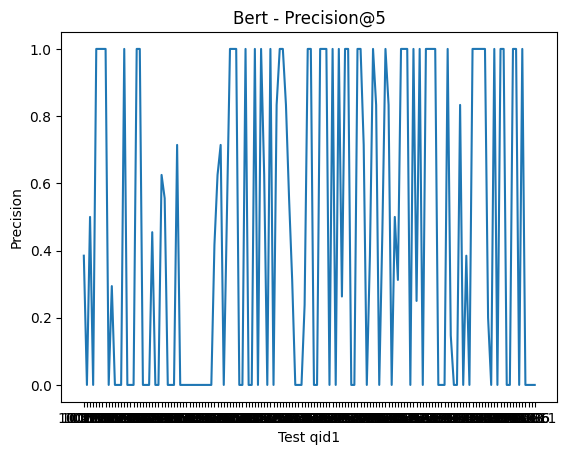

In [ ]:
xpoints = unique_qid1
ypoints = precision5
fig, ax = plt.subplots()
plt.plot(xpoints, ypoints)
plt.xlabel('Test qid1')
plt.ylabel('Precision')
plt.title('Bert - Precision@5')
plt.show()
fig.savefig("bert_precision5.svg", dpi=1200)

# Neural Network

## Word2Vecotr

In [ ]:
train_texts_1 = []
train_texts_2 = []
train_labels = []
train_ids = []

qid2 = []
for i in range(len(train_data)) :
    qid2.append(train_data[i][2])

unique_res = list(np.unique(qid2))

for id in unique_res :
    index = qid2.index(id)
    train = train_data[index]
    train_ids.append(train[0])
    train_texts_1.append(remove_stopwords(train[3].lower()))
    train_texts_2.append(remove_stopwords(train[4].lower()))
    train_labels.append(int(train[5]))

print('Found %s texts in train.csv' % len(train_texts_2))

valid_texts_1 = []
valid_texts_2 = []
valid_labels = []
valid_ids = []

for valid in valid_data :
    valid_ids.append(valid[0])
    valid_texts_1.append(remove_stopwords(valid[3].lower()))
    valid_texts_2.append(remove_stopwords(valid[4].lower()))
    valid_labels.append(int(valid[5]))

print('Found %s texts in valid.csv' % len(valid_texts_2))

texts_1 = []
texts_2 = []
labels = []
ids = []

texts_1.extend(train_texts_1)
texts_1.extend(valid_texts_1)

texts_2.extend(train_texts_2)
texts_2.extend(valid_texts_2)

labels.extend(train_labels)
labels.extend(valid_labels)

ids.extend(train_ids)
ids.extend(valid_ids)

test_texts_1 = []
test_texts_2 = []
test_labels = []
test_ids = []

qid1 = []
for i in range(len(test_data)) :
    qid1.append(test_data[i][1])
unique_qid1 = list(np.unique(qid1))
for id in unique_qid1 :
    index = qid1.index(id)
    test = test_data[index]
    test_ids.append(test[0])
    test_texts_1.append(remove_stopwords(test[3].lower()))
    test_texts_2.append(remove_stopwords(test[4].lower()))
    test_labels.append(int(test[5]))

print('Found %s texts in test.csv' % len(test_texts_1))

def remove_stop_words(document) :
    tokens = [list(tokenize(doc, lower=True)) for doc in document]
    tokens = [preprocess_string(" ".join(doc), [remove_stopwords, stem_text]) for doc in tokens]
    return tokens

def remove_stop_words2(sentences) :
    for i in range(len(sentences)) :
        sentences[i] = remove_stopwords(sentences[i].lower())
    
    return sentences

MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 30000
FEATURE_DIMENSION = 100
MIN_COUNT = 10
WINDOW = 5
EPOCHS = 20
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.1

text_corpus = []
text_corpus.extend(texts_1)
text_corpus.extend(texts_2)
text_corpus.extend(test_texts_1)
text_corpus.extend(test_texts_2)

class ProcessedText:
    def __init__(self, text):
        self.text = text

    def __iter__(self):
        for line in self.text:
            yield simple_preprocess(line)
            
wv_model = Word2Vec(vector_size=FEATURE_DIMENSION, window=WINDOW, min_count=MIN_COUNT, workers=4)
wv_model.build_vocab(ProcessedText(text_corpus), update=False)
wv_model.train(ProcessedText(text_corpus), total_examples=wv_model.corpus_count, epochs=EPOCHS)

print('Found %s word vectors of word2vec' % len(list(wv_model.wv.index_to_key)))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)

sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(labels)
ids = np.array(ids)
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)

test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
test_ids = np.array(test_ids)
test_labels = np.array(test_labels)

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, FEATURE_DIMENSION))
for word, i in word_index.items():
    if word in list(wv_model.wv.index_to_key) :
        embedding_matrix[i] = wv_model.wv[word]
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))


### Word2Vector LSTM

In [ ]:
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

embedding_layer = Embedding(input_dim=nb_words, 
                        output_dim=FEATURE_DIMENSION, 
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False)

lstm_layer = LSTM(units=256, return_sequences=True)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation='relu')(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[sequence_1_input, sequence_2_input], \
        outputs=preds)

model.compile(loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])

print(model.summary())

model.fit([data_1, data_2], labels, 
        validation_split = VALIDATION_SPLIT, 
        epochs = EPOCHS,
        shuffle = True, 
        batch_size = BATCH_SIZE)

model.save('./result/wv_lstm.h5')
print("Mission completed")

### Word2Vector Bi-LSTM

In [ ]:
first_sent_in = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
second_sent_in = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer =  Embedding(input_dim=nb_words, 
                        output_dim=FEATURE_DIMENSION, 
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH, 
                        trainable=True, 
                        mask_zero=True)


first_sent_embedding = embedding_layer(first_sent_in)
second_sent_embedding = embedding_layer(second_sent_in)

bilstm =  Bidirectional(LSTM(units=256, return_sequences=False))

first_sent_encoded = bilstm(first_sent_embedding)
second_sent_encoded = bilstm(second_sent_embedding)

function = lambda x: 1 - K.abs(x[0] - x[1])
output_shape = lambda x: x[0]
merged = Lambda(function=function, 
            output_shape=output_shape, 
            name='L1_distance')([first_sent_encoded, second_sent_encoded])
        
predictions = Dense(1, activation='sigmoid', name='classification_layer')(merged)

model = Model([first_sent_in, second_sent_in], predictions)

model.compile(loss = 'binary_crossentropy', 
            optimizer = "adam", 
            metrics=["accuracy"])

print(model.summary())

model.fit([data_1, data_2], labels, 
        validation_split = VALIDATION_SPLIT, 
        epochs = EPOCHS,
        shuffle = True, 
        batch_size = BATCH_SIZE)

model.save('./result/wv_bi_lstm.h5')
print("Mission completed")

## FastText

In [ ]:
train_texts_1 = []
train_texts_2 = []
train_labels = []
train_ids = []

qid2 = []
for i in range(len(train_data)) :
    qid2.append(train_data[i][2])

unique_res = list(np.unique(qid2))

for id in unique_res :
    index = qid2.index(id)
    train = train_data[index]
    train_ids.append(train[0])
    train_texts_1.append(remove_stopwords(train[3].lower()))
    train_texts_2.append(remove_stopwords(train[4].lower()))
    train_labels.append(int(train[5]))

print('Found %s texts in train.csv' % len(train_texts_2))

valid_texts_1 = []
valid_texts_2 = []
valid_labels = []
valid_ids = []

for valid in valid_data :
    valid_ids.append(valid[0])
    valid_texts_1.append(remove_stopwords(valid[3].lower()))
    valid_texts_2.append(remove_stopwords(valid[4].lower()))
    valid_labels.append(int(valid[5]))

print('Found %s texts in valid.csv' % len(valid_texts_2))

texts_1 = []
texts_2 = []
labels = []
ids = []

texts_1.extend(train_texts_1)
texts_1.extend(valid_texts_1)

texts_2.extend(train_texts_2)
texts_2.extend(valid_texts_2)

labels.extend(train_labels)
labels.extend(valid_labels)

ids.extend(train_ids)
ids.extend(valid_ids)

test_texts_1 = []
test_texts_2 = []
test_labels = []
test_ids = []

qid1 = []
for i in range(len(test_data)) :
    qid1.append(test_data[i][1])
unique_qid1 = list(np.unique(qid1))
for id in unique_qid1 :
    index = qid1.index(id)
    test = test_data[index]
    test_ids.append(test[0])
    test_texts_1.append(remove_stopwords(test[3].lower()))
    test_texts_2.append(remove_stopwords(test[4].lower()))
    test_labels.append(int(test[5]))

print('Found %s texts in test.csv' % len(test_texts_1))

def remove_stop_words(document) :
    tokens = [list(tokenize(doc, lower=True)) for doc in document]
    tokens = [preprocess_string(" ".join(doc), [remove_stopwords, stem_text]) for doc in tokens]
    return tokens

def remove_stop_words2(sentences) :
    for i in range(len(sentences)) :
        sentences[i] = remove_stopwords(sentences[i].lower())
    
    return sentences

MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 30000
FEATURE_DIMENSION = 100
MIN_COUNT = 10
WINDOW = 5
EPOCHS = 20
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.1

text_corpus = []
text_corpus.extend(texts_1)
text_corpus.extend(texts_2)
text_corpus.extend(test_texts_1)
text_corpus.extend(test_texts_2)

class ProcessedText:
    def __init__(self, text):
        self.text = text

    def __iter__(self):
        for line in self.text:
            yield simple_preprocess(line)
            
ft_model = FastText(vector_size=FEATURE_DIMENSION, window=WINDOW, min_count=MIN_COUNT, epochs=10)
ft_model.build_vocab(ProcessedText(text_corpus), update=False)
ft_model.train(ProcessedText(text_corpus), total_examples=ft_model.corpus_count, epochs=EPOCHS)

print('Found %s word vectors of FastText' % len(list(ft_model.wv.index_to_key)))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)

sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(labels)
ids = np.array(ids)
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)

test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
test_ids = np.array(test_ids)
test_labels = np.array(test_labels)

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, FEATURE_DIMENSION))
for word, i in word_index.items():
    if word in list(ft_model.wv.index_to_key) :
        embedding_matrix[i] = ft_model.wv[word]
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))


### FastText LSTM

In [ ]:
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

embedding_layer = Embedding(input_dim=nb_words, 
                        output_dim=FEATURE_DIMENSION, 
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False)

lstm_layer = LSTM(units=256, return_sequences=True)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation='relu')(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[sequence_1_input, sequence_2_input], \
        outputs=preds)

model.compile(loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])

print(model.summary())

model.fit([data_1, data_2], labels, 
        validation_split = VALIDATION_SPLIT, 
        epochs = EPOCHS,
        shuffle = True, 
        batch_size = BATCH_SIZE)

model.save('./result/ft_lstm.h5')
print("Mission completed")

### FastText Bi-LSTM

In [ ]:
first_sent_in = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
second_sent_in = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer =  Embedding(input_dim=nb_words, 
                        output_dim=FEATURE_DIMENSION, 
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH, 
                        trainable=True, 
                        mask_zero=True)


first_sent_embedding = embedding_layer(first_sent_in)
second_sent_embedding = embedding_layer(second_sent_in)

bilstm =  Bidirectional(LSTM(units=256, return_sequences=False))

first_sent_encoded = bilstm(first_sent_embedding)
second_sent_encoded = bilstm(second_sent_embedding)

function = lambda x: 1 - K.abs(x[0] - x[1])
output_shape = lambda x: x[0]
merged = Lambda(function=function, 
            output_shape=output_shape, 
            name='L1_distance')([first_sent_encoded, second_sent_encoded])
        
predictions = Dense(1, activation='sigmoid', name='classification_layer')(merged)

model = Model([first_sent_in, second_sent_in], predictions)

model.compile(loss = 'binary_crossentropy', 
            optimizer = "adam", 
            metrics=["accuracy"])

print(model.summary())

model.fit([data_1, data_2], labels, 
        validation_split = VALIDATION_SPLIT, 
        epochs = EPOCHS,
        shuffle = True, 
        batch_size = BATCH_SIZE)

model.save('./result/ft_bi_lstm.h5')
print("Mission completed")

## Load and Predict Model

In [ ]:
model = tf.keras.models.load_model('./result/ft_bi_lstm.h5', compile=False)
model.summary()

In [ ]:
prediction = []
count = 0
for i in range(0, len(test_data_2)):
    test = test_data_2[i]
    pr = []
    te = tf.convert_to_tensor([list(test)])
    for train in data_2 :
        tr = tf.convert_to_tensor([list(train)])
        pr.append(model.predict([tr, te]))
    prediction.append(pr)

    if len(prediction) % 10 == 0 :
        save_list(prediction, count)
        count += 1

In [ ]:
xpoints = unique_qid1
ypoints = precision5
fig, ax = plt.subplots()
plt.plot(xpoints, ypoints)
plt.xlabel('Test qid1')
plt.ylabel('Precision')
plt.title('Word2Vector - LSTM - Precision@5')
plt.show()
fig.savefig("wv_precision5.svg", dpi=1200)